In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from transformers import TFAutoModel, AutoTokenizer


In [ ]:
import pandas as pd


# Load datasets
news_data = pd.read_csv("/content/ISLAMI(News for day).csv")  # News dataset with 'Date' and 'News'
historical_data = pd.read_csv("/content/ISLAMI (Day).csv")  # Historical stock data with 'Date' and features

# Preview datasets
print(news_data.head())  # Should contain 'Date' and 'News'
print(historical_data.head())  # Should contain 'Date' and stock features


         Date                                               News
0  2021-04-19  As per Regulation 191 of the Dhaka Stock Excha...
1  2021-04-25  The Company has further informed that, due to ...
2  2021-04-28  The Board of Directors has recommended 10 cash...
3  2021-05-17  Trading of the shares of the Company will be a...
4  2021-05-19  Trading of the shares of the Company will rema...
         Date  Price  Open  High   Low      Vol.
0  2024-12-30   48.4  48.0  48.6  47.5  634900.0
1  2024-12-29   47.7  48.0  48.3  47.5  517850.0
2  2024-12-26   47.7  49.4  49.4  47.0  557460.0
3  2024-12-24   48.7  46.7  49.1  46.2  889690.0
4  2024-12-23   46.5  47.1  47.5  46.3  321320.0


In [ ]:
news_data = news_data.iloc[::-1].reset_index(drop=True)
news_data = news_data.dropna()
news_data = news_data.reset_index(drop=True)

In [ ]:
historical_data.head(5)

,Date,Price,Open,High,Low,Vol.
0,2024-12-30,48.4,48.0,48.6,47.5,634900.0
1,2024-12-29,47.7,48.0,48.3,47.5,517850.0
2,2024-12-26,47.7,49.4,49.4,47.0,557460.0
3,2024-12-24,48.7,46.7,49.1,46.2,889690.0
4,2024-12-23,46.5,47.1,47.5,46.3,321320.0


In [ ]:
# Convert dates to datetime
news_data['Date'] = pd.to_datetime(news_data['Date'])
historical_data['Date'] = pd.to_datetime(historical_data['Date'])

# Ensure both datasets are sorted by date
news_data = news_data.sort_values('Date').reset_index(drop=True)
historical_data = historical_data.sort_values('Date').reset_index(drop=True)

print(news_data.head())
print(historical_data.head())

        Date                                               News
0 2021-04-19  As per Regulation 191 of the Dhaka Stock Excha...
1 2021-04-25  The Company has further informed that, due to ...
2 2021-04-28  The Board of Directors has recommended 10 cash...
3 2021-05-17  Trading of the shares of the Company will be a...
4 2021-05-19  Trading of the shares of the Company will rema...
        Date  Price  Open  High   Low       Vol.
0 2021-01-03   26.8  26.6  26.9  26.3   593980.0
1 2021-01-04   27.5  26.7  27.9  26.7   824880.0
2 2021-01-05   28.4  27.8  30.2  27.7  2510000.0
3 2021-01-06   27.8  28.7  28.8  27.3  1370000.0
4 2021-01-07   28.2  28.2  28.9  28.0   728530.0


In [ ]:
news_data = news_data.iloc[::-1].reset_index(drop=True)
news_data.head(10)

,Date,News
0,2024-12-01,BSECs consent for issuance of IBBPLC Fifth Mud...
1,2024-10-31,Consolidated EPS was Tk. 0.55 for JulySeptembe...
2,2024-10-24,As per Regulation 161 of the Dhaka Stock Excha...
3,2024-09-26,In response to the DSE query dated September 2...
4,2024-09-19,Refer to their earlier news disseminated by DS...
5,2024-08-29,The company has informed that the Board of Dir...
6,2024-08-25,The company has informed that Mr. Mohammad Jah...
7,2024-08-07,The Company has informed that it has disbursed...
8,2024-07-31,Consolidated EPS was Tk. 1.91 for AprilJune 20...
9,2024-07-28,As per Regulation 161 of the Dhaka Stock Excha...


In [ ]:
historical_data = historical_data.iloc[::-1].reset_index(drop=True)
historical_data.head(10)

,Date,Price,Open,High,Low,Vol.
0,2024-12-30,48.4,48.0,48.6,47.5,634900.0
1,2024-12-29,47.7,48.0,48.3,47.5,517850.0
2,2024-12-26,47.7,49.4,49.4,47.0,557460.0
3,2024-12-24,48.7,46.7,49.1,46.2,889690.0
4,2024-12-23,46.5,47.1,47.5,46.3,321320.0
5,2024-12-22,47.1,48.1,48.2,47.0,330310.0
6,2024-12-19,47.6,47.9,47.9,47.2,309390.0
7,2024-12-18,47.9,49.9,49.9,47.7,831490.0
8,2024-12-17,49.5,48.0,50.0,48.0,930770.0
9,2024-12-15,47.7,46.2,48.0,45.7,683130.0


In [ ]:
# For historical_data
historical_data.fillna(method='ffill', inplace=True)

<ipython-input-9-547101b32549>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historical_data.fillna(method='ffill', inplace=True)


In [ ]:
# For news_data
news_data_null_counts = news_data.isnull().sum()
print("Null values in news_data:\n", news_data_null_counts)

# For historical_data
historical_data_null_counts = historical_data.isnull().sum()
print("\nNull values in historical_data:\n", historical_data_null_counts)

Null values in news_data:
 Date    0
News    0
dtype: int64

Null values in historical_data:
 Date     0
Price    0
Open     0
High     0
Low      0
Vol.     0
dtype: int64


In [ ]:
SEQ_LEN = 90  # Number of days for historical data
HISTORICAL_FEATURES = 5  # Exclude 'Date'

# Normalize historical data
historical_data.iloc[:, 1:] = (historical_data.iloc[:, 1:] - historical_data.iloc[:, 1:].mean()) / historical_data.iloc[:, 1:].std()

# Prepare training data
train_samples = []

for i, news_row in news_data.iterrows():
    news_date = news_row['Date']

    # Check if the news_date exists in historical_data
    if news_date not in historical_data['Date'].values:
        continue  # Skip this news item if the date is not found in historical data

    # Get the corresponding 90-day window from historical data
    hist_index = historical_data[historical_data['Date'] == news_date].index[0]

    if hist_index >= SEQ_LEN - 1:
        historical_window = historical_data.iloc[hist_index - SEQ_LEN + 1:hist_index + 1, 1:].values

        # Collect all news within the 90-day window
        news_within_window = news_data[
            (news_data['Date'] >= historical_data.iloc[hist_index - SEQ_LEN + 1]['Date']) &
            (news_data['Date'] <= news_date)
        ]

        train_samples.append({
            'news': list(news_within_window['News']),
            'historical_data': historical_window,
            'target': historical_data.iloc[hist_index]['Price']  # Ensure 'Price' is the target column
        })

# Filter out samples with missing target values (if any)
train_samples = [sample for sample in train_samples if not np.isnan(sample['target'])]


In [ ]:
# ipython-input-34-59bf81bb6b6b
from transformers import AutoTokenizer

# Initialize FinBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

# Tokenize news data
max_length = 512

def tokenize_news(news_list):
    combined_text = " ".join(news_list)  # Combine all news items for the sample
    tokens = tokenizer(
        combined_text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="np"
    )
    return tokens['input_ids'][0], tokens['attention_mask'][0] #Squeeze the extra dimension

# Tokenize the news for each sample
news_input_ids = []
news_attention_masks = []
historical_inputs = []
targets = []

for sample in train_samples:
    input_ids, attention_mask = tokenize_news(sample['news'])
    news_input_ids.append(input_ids)
    news_attention_masks.append(attention_mask)
    historical_inputs.append(sample['historical_data'])
    targets.append(sample['target'])

news_input_ids = np.array(news_input_ids)
news_attention_masks = np.array(news_attention_masks)
historical_inputs = np.array(historical_inputs)
targets = np.array(targets)

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training, validation, and test sets
X_news_train, X_news_test, X_news_mask_train, X_news_mask_test, \
X_historical_train, X_historical_test, y_train, y_test = train_test_split(
    news_input_ids, news_attention_masks, historical_inputs, targets,
    test_size=0.2, random_state=42
)

# Further split the training set into training and validation sets
X_news_train, X_news_val, X_news_mask_train, X_news_mask_val, \
X_historical_train, X_historical_val, y_train, y_val = train_test_split(
    X_news_train, X_news_mask_train, X_historical_train, y_train,
    test_size=0.2, random_state=42
)

In [ ]:
'''
from tensorflow.keras import layers
from transformers import TFBertModel
import tensorflow as tf

def build_multimodal_model():
    # Define input shapes
    seq_len = 512  # Updated sequence length
    hist_features = 5  # Number of historical stock features
    hist_seq_len = 90  # 90 days of historical stock data

    # Load FinBERT model
    finbert_model = TFBertModel.from_pretrained("yiyanghkust/finbert-tone")
    finbert_input_ids = tf.keras.layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_input_ids")
    finbert_attention_mask = tf.keras.layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_attention_mask")

    # Wrap FinBERT call in a Lambda layer with explicit output shape
    finbert_output = tf.keras.layers.Lambda(
        lambda x: finbert_model(x[0], attention_mask=x[1]).last_hidden_state,
        output_shape=(seq_len, finbert_model.config.hidden_size)  # Add output shape here
    )([finbert_input_ids, finbert_attention_mask])

    # Extract the [CLS] token output (usually the first token)
    finbert_cls_output = finbert_output[:, 0, :]  # Get the output for the [CLS] token

    # Historical stock data input
    historical_input = tf.keras.layers.Input(shape=(hist_seq_len, hist_features), name="historical_input")

    # Transformer encoder for historical stock data
    hist_attention = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=hist_features)(historical_input, historical_input)
    hist_output = tf.keras.layers.GlobalAveragePooling1D()(hist_attention)

    # Combine news and historical features
    combined_features = tf.keras.layers.Concatenate()([finbert_cls_output, hist_output])

    # Fully connected layers
    x = tf.keras.layers.Dense(128, activation="relu")(combined_features)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(1, activation="linear", name="price_output")(x)

    # Define the final model
    model = tf.keras.Model(
        inputs=[finbert_input_ids, finbert_attention_mask, historical_input],
        outputs=output
    )
    return model

    '''

'\nfrom tensorflow.keras import layers\nfrom transformers import TFBertModel\nimport tensorflow as tf\n\ndef build_multimodal_model():\n    # Define input shapes\n    seq_len = 512  # Updated sequence length\n    hist_features = 5  # Number of historical stock features\n    hist_seq_len = 90  # 90 days of historical stock data\n\n    # Load FinBERT model\n    finbert_model = TFBertModel.from_pretrained("yiyanghkust/finbert-tone")\n    finbert_input_ids = tf.keras.layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_input_ids")\n    finbert_attention_mask = tf.keras.layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_attention_mask")\n\n    # Wrap FinBERT call in a Lambda layer with explicit output shape\n    finbert_output = tf.keras.layers.Lambda(\n        lambda x: finbert_model(x[0], attention_mask=x[1]).last_hidden_state,\n        output_shape=(seq_len, finbert_model.config.hidden_size)  # Add output shape here\n    )([finbert_input_ids, finbert_attention_mask])\n\

In [ ]:

#Model 1
'''

from tensorflow.keras import layers, Model
from transformers import TFBertModel
import tensorflow as tf
from tensorflow.keras import regularizers


class FinBERTLayer(layers.Layer):
    def __init__(self, model_name="yiyanghkust/finbert-tone", **kwargs):
        super(FinBERTLayer, self).__init__(**kwargs)
        self.finbert = TFBertModel.from_pretrained(model_name)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]  # CLS token


def build_multimodal_stock_model(seq_len=512, hist_features=5, hist_seq_len=90 , l2_lambda=0.001):
    # Inputs for textual data (FinBERT)
    finbert_input_ids = layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_input_ids")
    finbert_attention_mask = layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_attention_mask")

    # FinBERT model wrapped in a custom layer
    finbert_output = FinBERTLayer()([finbert_input_ids, finbert_attention_mask])
    news_context_vector = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda), name="news_dense")(finbert_output)

    # Inputs for numerical data (historical stock data)
    historical_input = layers.Input(shape=(hist_seq_len, hist_features), name="historical_input")

    # Transformer for historical stock data
    hist_transformer = layers.MultiHeadAttention(num_heads=4, key_dim=hist_features)(historical_input, historical_input)
    hist_context_vector = layers.GlobalAveragePooling1D()(hist_transformer)

    # Project historical context vector to the same dimension as FinBERT output (128)
    hist_context_projected = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda), name="hist_dense")(hist_context_vector)

    # Cross-Attention-Based Fusion
    fusion = layers.MultiHeadAttention(num_heads=4, key_dim=128)(
        news_context_vector[:, tf.newaxis, :], hist_context_projected[:, tf.newaxis, :]
    )
    fusion = layers.GlobalAveragePooling1D()(fusion)

    # Dense or pooling layer
    combined_vector = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda), name="fusion_dense")(fusion)
    combined_vector = layers.Dropout(0.2)(combined_vector)

    # Transformer for final prediction
    combined_transformer = layers.MultiHeadAttention(num_heads=4, key_dim=64)(
        combined_vector[:, tf.newaxis, :], combined_vector[:, tf.newaxis, :]
    )
    final_vector = layers.GlobalAveragePooling1D()(combined_transformer)

    # Output dense layer
    price_output = layers.Dense(1, activation="linear", kernel_regularizer=regularizers.l2(l2_lambda), name="price_output")(final_vector)

    # Build the model
    model = Model(
        inputs=[finbert_input_ids, finbert_attention_mask, historical_input],
        outputs=price_output,
    )

    return model
'''

'\n\nfrom tensorflow.keras import layers, Model\nfrom transformers import TFBertModel\nimport tensorflow as tf\nfrom tensorflow.keras import regularizers\n\n\nclass FinBERTLayer(layers.Layer):\n    def __init__(self, model_name="yiyanghkust/finbert-tone", **kwargs):\n        super(FinBERTLayer, self).__init__(**kwargs)\n        self.finbert = TFBertModel.from_pretrained(model_name)\n\n    def call(self, inputs):\n        input_ids, attention_mask = inputs\n        outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)\n        return outputs.last_hidden_state[:, 0, :]  # CLS token\n\n\ndef build_multimodal_stock_model(seq_len=512, hist_features=5, hist_seq_len=90 , l2_lambda=0.001):\n    # Inputs for textual data (FinBERT)\n    finbert_input_ids = layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_input_ids")\n    finbert_attention_mask = layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_attention_mask")\n\n    # FinBERT model wrapped in a custo

In [ ]:
from tensorflow.keras import layers, Model, optimizers
from transformers import TFBertModel
import tensorflow as tf
from tensorflow.keras import regularizers

def build_historical_transformer(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.LayerNormalization()(inputs)

    # Transformer Encoder block
    x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)

    # Pooling and output
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(128, activation='relu', name="hist_dense_transformed")(x)  # Match FinBERT output dimension

    model = tf.keras.Model(inputs, outputs)
    return model

class FinBERTLayer(layers.Layer):
    def __init__(self, model_name="yiyanghkust/finbert-tone", **kwargs):
        super(FinBERTLayer, self).__init__(**kwargs)
        self.finbert = TFBertModel.from_pretrained(model_name)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]  # CLS token

def build_multimodal_stock_model(seq_len=512, hist_features=5, hist_seq_len=90, l2_lambda=0.01, learning_rate=0.002):
    # Inputs for textual data (FinBERT)
    finbert_input_ids = layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_input_ids")
    finbert_attention_mask = layers.Input(shape=(seq_len,), dtype=tf.int32, name="finbert_attention_mask")

    # FinBERT model wrapped in a custom layer
    finbert_output = FinBERTLayer()([finbert_input_ids, finbert_attention_mask])
    news_context_vector = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda), name="news_dense")(finbert_output)

    # Inputs for numerical data (historical stock data)
    historical_input = layers.Input(shape=(hist_seq_len, hist_features), name="historical_input")

    # Historical Transformer Model
    historical_transformer_model = build_historical_transformer((hist_seq_len, hist_features))
    hist_context_vector = historical_transformer_model(historical_input)

    # Cross-Attention-Based Fusion
    fusion = layers.MultiHeadAttention(num_heads=4, key_dim=128)(
        news_context_vector[:, tf.newaxis, :], hist_context_vector[:, tf.newaxis, :]
    )
    fusion = layers.GlobalAveragePooling1D()(fusion)

    # Dense or pooling layer
    combined_vector = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda), name="fusion_dense")(fusion)
    combined_vector = layers.Dropout(0.2)(combined_vector)

    # Transformer for final prediction
    combined_transformer = layers.MultiHeadAttention(num_heads=4, key_dim=64)(
        combined_vector[:, tf.newaxis, :], combined_vector[:, tf.newaxis, :]
    )
    final_vector = layers.GlobalAveragePooling1D()(combined_transformer)

    # Output dense layer
    price_output = layers.Dense(1, activation="linear", kernel_regularizer=regularizers.l2(l2_lambda), name="price_output")(final_vector)

    # Build the model
    model = Model(
        inputs=[finbert_input_ids, finbert_attention_mask, historical_input],
        outputs=price_output,
    )

    # Compile the model with learning rate
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


In [ ]:
model = build_multimodal_stock_model()
model.compile(optimizer="adam", loss="mse", metrics=["mae"])



tf_model.h5:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Train the model
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(
    x=[X_news_train, X_news_mask_train, X_historical_train],
    y=y_train,
    validation_data=([X_news_val, X_news_mask_val, X_historical_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step - loss: 3.2404 - mae: 0.3044 - val_loss: 2.9898 - val_mae: 0.0565
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 3.0933 - mae: 0.2113 - val_loss: 2.9095 - val_mae: 0.1184
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2.9496 - mae: 0.1920 - val_loss: 2.8536 - val_mae: 0.2006
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.8517 - mae: 0.1928 - val_loss: 2.7480 - val_mae: 0.1179
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.7400 - mae: 0.1045 - val_loss: 2.6492 - val_mae: 0.0659
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.6455 - mae: 0.0629 - val_loss: 2.5603 - val_mae: 0.0774
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.5689 - mae: 0.0916 - val_loss: 2.4789 - val_mae: 0.0773
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2.4873 - mae: 0.0938 - val_loss: 2.4020 - val_mae: 0.0704
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.4038 - mae: 0.0687 - val_los

In [ ]:
# Evaluate on the test set
loss, mae = model.evaluate(
    x=[X_news_test, X_news_mask_test, X_historical_test],
    y=y_test
)

print(f"Test Loss: {loss}")
print(f"Test Mean Absolute Error (MAE): {mae}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.1564 - mae: 0.0600
Test Loss: 0.15643522143363953
Test Mean Absolute Error (MAE): 0.06001380458474159


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0817 - mae: 0.1259
Test Loss: 0.08174573630094528[l2 = 0.001]
Test Mean Absolute Error (MAE): 0.12589506804943085

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.0193 - mae: 0.1248
Test Loss: 0.0192932840436697
Test Mean Absolute Error (MAE): 0.12475866079330444 (No regularization)

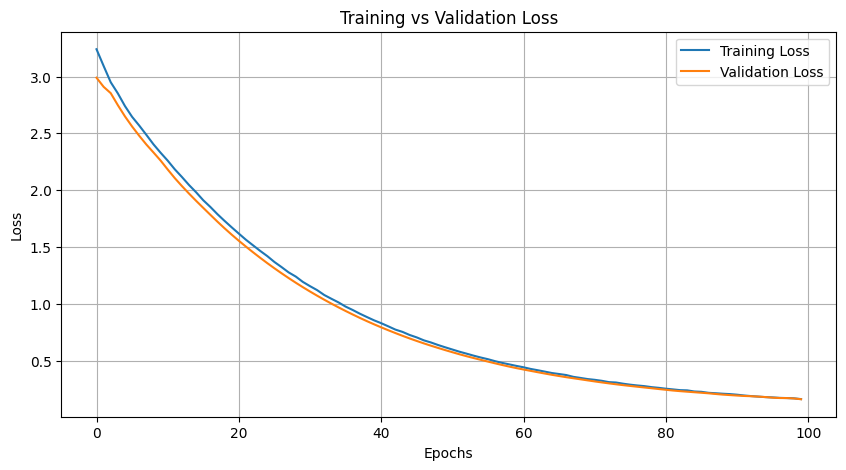

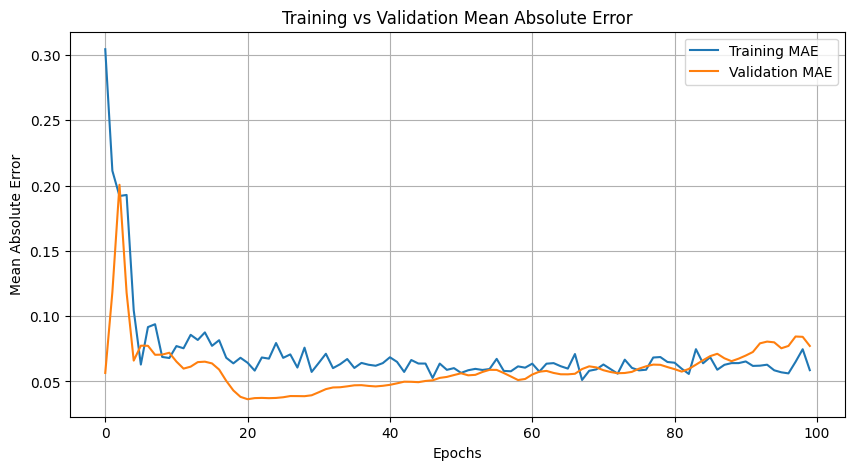

In [ ]:
import matplotlib.pyplot as plt

# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training vs validation MAE (or another metric)
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training vs Validation Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


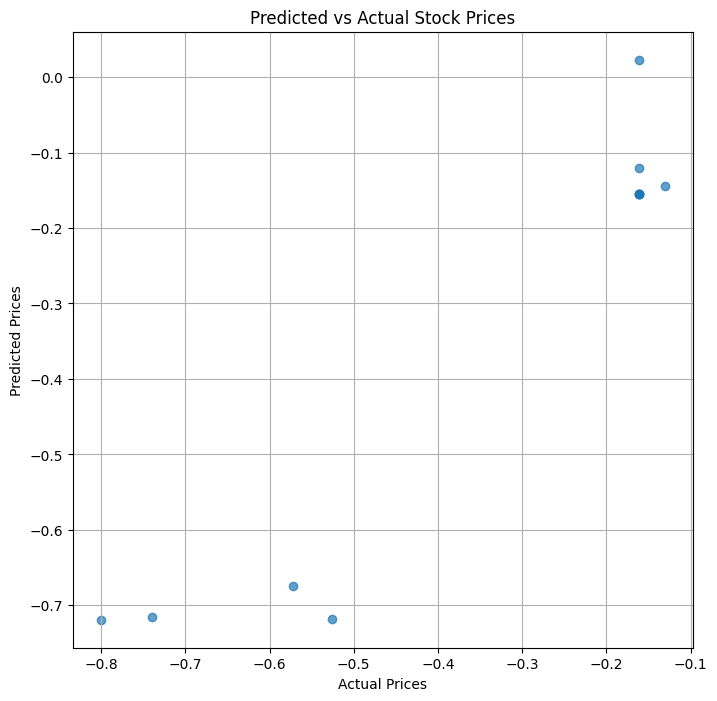

In [ ]:
# Get predictions for the test set
predictions = model.predict([X_news_test, X_news_mask_test, X_historical_test])

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, predictions, alpha=0.7)
plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)
plt.show()


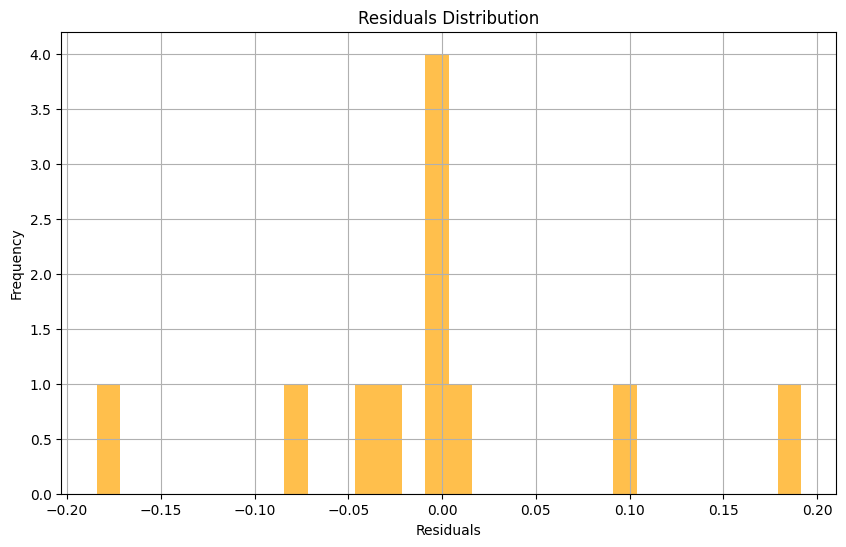

In [ ]:
# Calculate residuals
residuals = y_test - predictions.flatten()

# Plot residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='orange')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


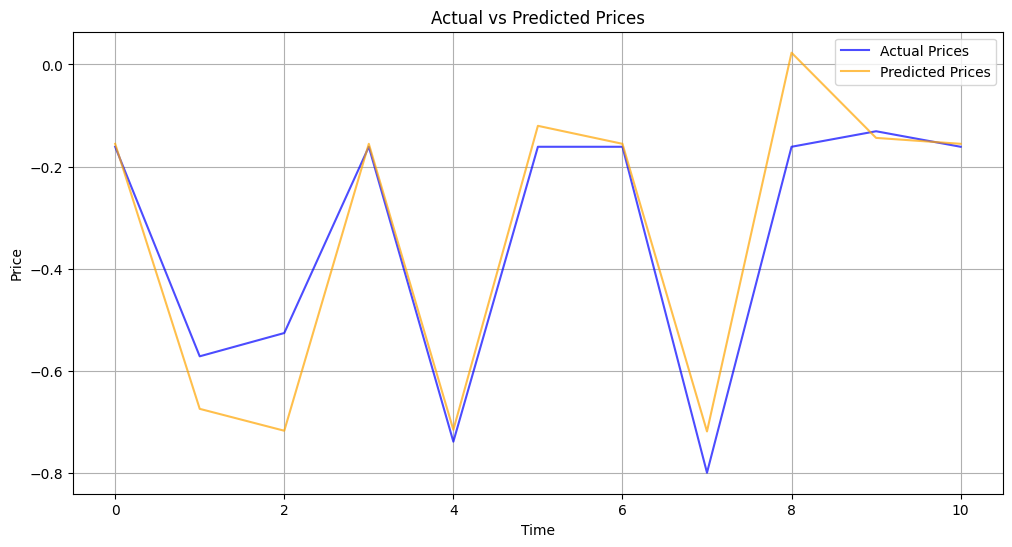

In [ ]:
import matplotlib.pyplot as plt

# Generate predictions
y_pred = model.predict([X_news_test, X_news_mask_test, X_historical_test]).flatten()

# Plot the Actual vs Predicted graph
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices", color="blue", alpha=0.7)
plt.plot(y_pred, label="Predicted Prices", color="orange", alpha=0.7)
plt.title("Actual vs Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


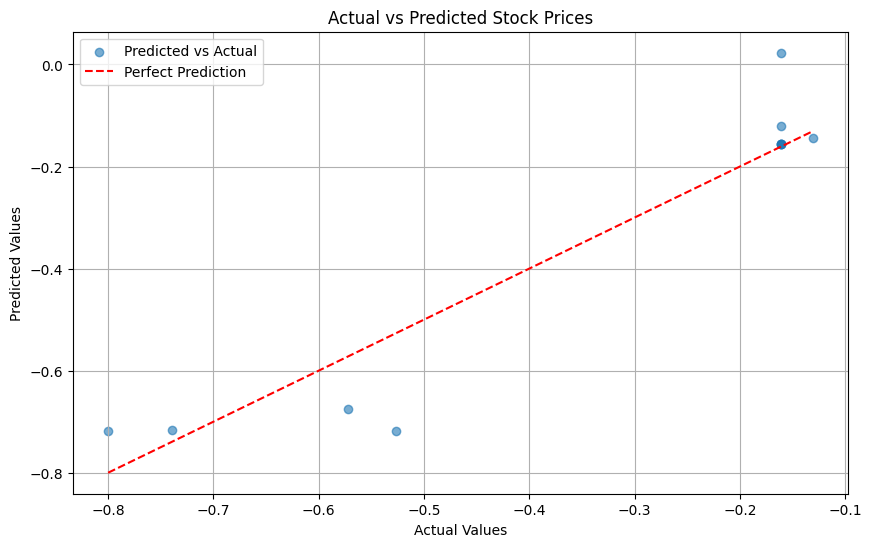

In [ ]:
# Make predictions on the test set
predictions = model.predict([X_news_test, X_news_mask_test, X_historical_test])
predictions = predictions.flatten()  # Flatten predictions

# Actual values
actual = y_test

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(actual, predictions, alpha=0.6, label="Predicted vs Actual")
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color="red", linestyle="--", label="Perfect Prediction")  # Reference line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save("multimodal_stock_price_model.keras")


In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer

# Register custom objects
custom_objects = {"FinBERTLayer": FinBERTLayer, "build_historical_transformer": build_historical_transformer}

# Load the model
model = tf.keras.models.load_model("multimodal_stock_price_model.keras", custom_objects=custom_objects)

# Load FinBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")


Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer

# Load FinBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

def preprocess_news(news_csv):
    """Loads news CSV and tokenizes the latest news using FinBERT."""
    df = pd.read_csv(news_csv)

    # Assuming 'News' is the column with news
    latest_news = df['News'].iloc[0]  # Take the latest news item

    encoded = tokenizer(latest_news,
                        padding="max_length",
                        truncation=True,
                        max_length=512,
                        return_tensors="np")

    return encoded["input_ids"][0], encoded["attention_mask"][0]  # Remove extra batch dim

def preprocess_historical_data(stock_csv):
    """Loads stock CSV, keeps last 90 days, and formats it correctly."""
    df = pd.read_csv(stock_csv)

    # Convert 'Date' column to datetime and sort
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').tail(90)  # Keep last 90 days

    # Compute mean and std for denormalization
    price_mean = df['Price'].mean()
    price_std = df['Price'].std()

    # Normalize data (excluding Date column)
    df.iloc[:, 1:] = (df.iloc[:, 1:] - df.iloc[:, 1:].mean()) / df.iloc[:, 1:].std()

    # Padding with zeros if less than 90 days
    if len(df) < 90:
        padding_shape = (90 - len(df), df.shape[1] - 1)  # Exclude 'Date' column
        padding_data = np.zeros(padding_shape)
        padding_df = pd.DataFrame(padding_data, columns=df.columns[1:])  # Exclude 'Date' column
        df = pd.concat([padding_df, df.drop(columns=['Date'])], ignore_index=True)
    else:
        df = df.drop(columns=['Date'])  # If already 90 days, drop 'Date'

    stock_features = df.values  # Get numerical data
    return np.expand_dims(stock_features, axis=0), price_mean, price_std  # Add batch dim, return mean & std

# Load model
#model = tf.keras.models.load_model("multimodal_stock_price_model.keras")

def predict_next_day_price(news_csv, stock_csv):
    """Predicts next-day stock price and converts it back to actual form."""
    # Process news and historical data
    news_input_ids, news_attention_mask = preprocess_news(news_csv)  # Shape: (1, 512)
    historical_data, price_mean, price_std = preprocess_historical_data(stock_csv)  # Shape: (1, 90, 5)

    # Run prediction
    predicted_price = model.predict([np.expand_dims(news_input_ids, axis=0),
                                     np.expand_dims(news_attention_mask, axis=0),
                                     historical_data])

    # Denormalize the predicted price
    actual_price = (predicted_price[0][0] * price_std) + price_mean

    print(f"Predicted Stock Price for the Next Day: {actual_price:.2f}")

# Example usage
predict_next_day_price("/content/ISLAMI NT.csv", "/content/ISMB (90 Day).csv")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Stock Price for the Next Day: 51.40


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.graph_objects as go
from transformers import AutoTokenizer

# Load FinBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

def preprocess_news(news_csv):
    """Loads news CSV and tokenizes the latest news using FinBERT."""
    df = pd.read_csv(news_csv)

    # Assuming 'News' is the column with news
    latest_news = df['News'].iloc[0]  # Take the latest news item

    encoded = tokenizer(latest_news,
                        padding="max_length",
                        truncation=True,
                        max_length=512,
                        return_tensors="np")

    return encoded["input_ids"][0], encoded["attention_mask"][0]  # Remove extra batch dim

def preprocess_historical_data(stock_csv):
    """Loads stock CSV, keeps last 90 days, and formats it correctly."""
    df = pd.read_csv(stock_csv)

    # Strip whitespace from column names
    df.columns = df.columns.str.strip()

    # Check if 'Date' exists
    if 'Date' not in df.columns:
        raise KeyError("Column 'Date' not found in CSV. Check the column names:", df.columns)

    # Convert 'Date' to datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Sort and keep last 90 days
    df = df.sort_values('Date').tail(90)

    # Compute mean and std for denormalization
    price_mean = df['Price'].mean()
    price_std = df['Price'].std()

    # Normalize data (excluding Date column)
    df.iloc[:, 1:] = (df.iloc[:, 1:] - df.iloc[:, 1:].mean()) / df.iloc[:, 1:].std()

    # Drop 'Date' but store for later use
    dates = df['Date']
    df = df.drop(columns=['Date'])

    stock_features = df.values
    return np.expand_dims(stock_features, axis=0), price_mean, price_std, dates

# Load model
# model = tf.keras.models.load_model("multimodal_stock_price_model.keras")

def predict_next_day_price(news_csv, stock_csv):
    """Predicts next-day stock price and converts it back to actual form."""
    # Process news and historical data
    news_input_ids, news_attention_mask = preprocess_news(news_csv)  # Shape: (1, 512)
    historical_data, price_mean, price_std, dates = preprocess_historical_data(stock_csv)  # Shape: (1, 90, 5)

    # Run prediction
    predicted_price = model.predict([np.expand_dims(news_input_ids, axis=0),
                                     np.expand_dims(news_attention_mask, axis=0),
                                     historical_data])

    # Denormalize the predicted price
    actual_price = (predicted_price[0][0] * price_std) + price_mean

    print(f"Predicted Stock Price for the Next Day: {actual_price:.2f}")

    # Call plot function
    plot_stock_prices(stock_csv, actual_price)

def plot_stock_prices(stock_csv, predicted_price):
    """Plots historical stock prices and predicted next-day price."""
    df = pd.read_csv(stock_csv)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').tail(90)

    fig = go.Figure()

    # Add historical prices
    fig.add_trace(go.Scatter(
        x=df['Date'],
        y=df['Price'],
        mode='lines+markers',
        name='Historical Prices',
        hoverinfo='x+y'
    ))

    # Add predicted price
    next_date = df['Date'].max() + pd.Timedelta(days=1)
    fig.add_trace(go.Scatter(
        x=[next_date],
        y=[predicted_price],
        mode='markers',
        marker=dict(size=10, color='red'),
        name='Predicted Price',
        hoverinfo='x+y'
    ))

    # Update layout
    fig.update_layout(
        title="Stock Price Prediction",
        xaxis_title="Date",
        yaxis_title="Stock Price",
        hovermode="x",
        template="plotly_white"
    )

    fig.show()

# Example usage
predict_next_day_price("/content/ISLAMI NT.csv", "/content/ISMB (90 Day).csv")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Stock Price for the Next Day: 51.41


**Jan 26, 2025	45.20	**